In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [160]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn import metrics
import matplotlib.pyplot as plt

In [9]:
train = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

In [10]:
train_df = train.sort_values('TransactionDT').loc[:472432,:].reset_index(drop = True)
test_df = train.sort_values('TransactionDT').loc[472432:,:].reset_index(drop = True)

In [14]:
del train

In [15]:
useful_features = list(train_df.iloc[:, 3:55].columns)

In [21]:
y = train_df.sort_values('TransactionDT')['isFraud']
X = train_df.sort_values('TransactionDT')[useful_features]

In [22]:
y_test = test_df.sort_values('TransactionDT')['isFraud']
X_test = test_df.sort_values('TransactionDT')[useful_features]

In [18]:
categorical_features = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain',
    'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

continuous_features = list(filter(lambda x: x not in categorical_features, X))

In [25]:
class ContinuousFeatureConverter:
    def __init__(self, name, feature, log_transform):
        self.name = name
        self.skew = feature.skew()
        self.log_transform = log_transform
        
    def transform(self, feature):
        if self.skew > 1:
            feature = self.log_transform(feature)
        
        mean = feature.mean()
        std = feature.std()
        return (feature - mean)/(std + 1e-6)        

In [26]:
from tqdm.notebook import tqdm

feature_converters = {}
continuous_features_processed = []
continuous_features_processed_test = []

for f in tqdm(continuous_features):
    feature = X[f]
    feature_test = X_test[f]
    log = lambda x: np.log10(x + 1 - min(0, x.min()))
    converter = ContinuousFeatureConverter(f, feature, log)
    feature_converters[f] = converter
    continuous_features_processed.append(converter.transform(feature))
    continuous_features_processed_test.append(converter.transform(feature_test))
    
continuous_train = pd.DataFrame({s.name: s for s in continuous_features_processed}).astype(np.float32)
continuous_test = pd.DataFrame({s.name: s for s in continuous_features_processed_test}).astype(np.float32)

  0%|          | 0/32 [00:00<?, ?it/s]

In [27]:
continuous_train

,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,-0.151092,0.218624,NaN,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,NaN,NaN,NaN,NaN,0.014575,-0.709011,NaN,NaN,NaN,-0.803351
1,-1.050128,NaN,NaN,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,NaN,NaN,NaN,NaN,-1.015065,NaN,NaN,NaN,NaN,-0.803351
2,-0.308380,1.659774,NaN,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,NaN,NaN,NaN,NaN,-1.015065,1.187873,NaN,NaN,NaN,0.805930
3,-0.482294,NaN,NaN,-0.118744,0.575885,-0.058692,-0.384615,-0.500135,0.626698,-0.245169,...,NaN,NaN,NaN,NaN,0.718255,NaN,NaN,NaN,NaN,-0.236271
4,-0.482294,NaN,NaN,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472428,-0.503485,NaN,NaN,-0.530756,-0.123806,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,NaN,NaN,NaN,NaN,-1.015065,-0.948840,NaN,NaN,NaN,-0.803351
472429,-0.715851,NaN,NaN,-0.530756,-0.533099,-0.058692,0.798779,-0.500135,-0.355805,-0.245169,...,NaN,NaN,0.095129,-1.496624,NaN,NaN,NaN,NaN,NaN,NaN
472430,-1.722812,-0.806423,NaN,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,NaN,NaN,NaN,NaN,-0.203762,-0.813320,NaN,NaN,NaN,1.148221
472431,-0.503485,1.972760,NaN,-0.118744,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,NaN,NaN,NaN,NaN,0.569135,-0.147721,NaN,NaN,NaN,-0.512148


In [28]:
continuous_train['isna_sum'] = continuous_train.isna().sum(axis=1)
continuous_test['isna_sum'] = continuous_test.isna().sum(axis=1)

continuous_train['isna_sum'] = (continuous_train['isna_sum'] - continuous_train['isna_sum'].mean())/continuous_train['isna_sum'].std()
continuous_test['isna_sum'] = (continuous_test['isna_sum'] - continuous_test['isna_sum'].mean())/continuous_test['isna_sum'].std()

In [33]:
continuous_train['TransactionAmt'].isna().mean()

0.0

In [34]:
isna_columns = []
for column in tqdm(continuous_features):
    isna = continuous_train[column].isna()
    if isna.mean() > 0.:
        continuous_train[column + '_isna'] = isna.astype(int)
        continuous_test[column + '_isna'] = continuous_test[column].isna().astype(int)
        isna_columns.append(column)
        
continuous_train = continuous_train.fillna(0.)
continuous_test = continuous_test.fillna(0.)

  0%|          | 0/32 [00:00<?, ?it/s]

In [35]:
continuous_train

,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,...,D6_isna,D7_isna,D8_isna,D9_isna,D10_isna,D11_isna,D12_isna,D13_isna,D14_isna,D15_isna
0,-0.151092,0.218624,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,1,1,1,1,0,0,1,1,1,0
1,-1.050128,0.000000,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,1,1,1,1,0,1,1,1,1,0
2,-0.308380,1.659774,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,1,1,1,1,0,0,1,1,1,0
3,-0.482294,0.000000,0.0,-0.118744,0.575885,-0.058692,-0.384615,-0.500135,0.626698,-0.245169,...,1,1,1,1,0,1,1,1,1,0
4,-0.482294,0.000000,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472428,-0.503485,0.000000,0.0,-0.530756,-0.123806,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,1,1,1,1,0,0,1,1,1,0
472429,-0.715851,0.000000,0.0,-0.530756,-0.533099,-0.058692,0.798779,-0.500135,-0.355805,-0.245169,...,1,1,0,0,1,1,1,1,1,1
472430,-1.722812,-0.806423,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,1,1,1,1,0,0,1,1,1,0
472431,-0.503485,1.972760,0.0,-0.118744,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,1,1,1,1,0,0,1,1,1,0


In [41]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.notebook import tqdm

def categorical_encode(df_train, df_test, categorical_features, n_values=50):
    df_train = df_train[categorical_features].astype(str)
    df_test = df_test[categorical_features].astype(str)
    
    categories = []
    for column in tqdm(categorical_features):
        categories.append(list(df_train[column].value_counts().iloc[: n_values - 1].index) + ['Other'])
        values2use = categories[-1]
        df_train[column] = df_train[column].apply(lambda x: x if x in values2use else 'Other')
        df_test[column] = df_test[column].apply(lambda x: x if x in values2use else 'Other')
        
    
    ohe = OneHotEncoder(categories=categories)
    ohe.fit(pd.concat([df_train, df_test]))
    df_train = pd.DataFrame(ohe.transform(df_train).toarray()).astype(np.float16)
    df_test = pd.DataFrame(ohe.transform(df_test).toarray()).astype(np.float16)
    return df_train, df_test

In [42]:
train_categorical, test_categorical = categorical_encode(X, X_test, categorical_features)

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
X = pd.concat([continuous_train, train_categorical], axis=1)
del continuous_train, train_categorical
X_test = pd.concat([continuous_test, test_categorical], axis=1)
del continuous_test, test_categorical

In [44]:
split_ind = int(X.shape[0]*0.8)

X_tr = X.iloc[:split_ind]
X_val = X.iloc[split_ind:]

y_tr = y.iloc[:split_ind]
y_val = y.iloc[split_ind:]

del X

In [45]:
X_tr

,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,...,445,446,447,448,449,450,451,452,453,454
0,-0.151092,0.218624,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.050128,0.000000,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.308380,1.659774,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.482294,0.000000,0.0,-0.118744,0.575885,-0.058692,-0.384615,-0.500135,0.626698,-0.245169,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.482294,0.000000,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,-0.355805,-0.245169,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377941,0.415382,-1.400023,0.0,-0.118744,0.166592,-0.058692,-0.384615,-0.500135,0.626698,-0.245169,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
377942,-0.402076,-0.650984,0.0,0.997608,0.575885,-0.058692,-0.384615,0.588212,0.626698,-0.245169,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
377943,1.535179,-0.806423,0.0,-0.530756,-0.533099,-0.058692,-0.384615,-0.500135,0.078959,-0.245169,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
377944,0.329991,-0.530415,0.0,-0.530756,-0.123806,-0.058692,-0.384615,0.186536,-0.355805,-0.245169,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [56]:
import keras
import random
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [57]:
# Compatible with tensorflow backend
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_val: %s' % (str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
    
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1))-K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Activation(custom_gelu)})
get_custom_objects().update({'focal_loss_fn': focal_loss()})

In [71]:
def create_model(loss_fn):
    inps = Input(shape=(X_tr.shape[1],))
    x = Dense(512, activation=custom_gelu)(inps)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation=custom_gelu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    logits = Dense(1, name='logits')(x)
    x = tf.keras.activations.sigmoid(logits)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer=Nadam(),
        loss=[loss_fn]
    )
    #model.summary()
    return model

In [73]:
model_focal = create_model('focal_loss_fn')
model_bce = create_model('binary_crossentropy')

In [74]:
model_bce.fit(
    X_tr, y_tr, epochs=8, batch_size=2048, validation_data=(X_val, y_val), verbose=True, 
    callbacks=[roc_callback(training_data=(X_val, y_tr), validation_data=(X_val, y_val))]
)

Epoch 1/8
185/185 [==============================] - 22s 107ms/step - loss: 0.3029 - val_loss: 0.1296
roc-auc_val: 0.8808                                                                                                    
Epoch 2/8
185/185 [==============================] - 19s 101ms/step - loss: 0.1042 - val_loss: 0.1190
roc-auc_val: 0.8868                                                                                                    
Epoch 3/8
185/185 [==============================] - 18s 96ms/step - loss: 0.0923 - val_loss: 0.1144
roc-auc_val: 0.8935                                                                                                    
Epoch 4/8
185/185 [==============================] - 18s 99ms/step - loss: 0.0849 - val_loss: 0.1089
roc-auc_val: 0.892                                                                                                    
Epoch 5/8
185/185 [==============================] - 21s 116ms/step - loss: 0.0789 - val_loss: 0.1086
roc-auc_val: 

In [75]:
model_focal.fit(
    X_tr, y_tr, epochs=8, batch_size=2048, validation_data=(X_val, y_val), verbose=True, 
    callbacks=[roc_callback(training_data=(X_val, y_tr), validation_data=(X_val, y_val))]
)

Epoch 1/8
185/185 [==============================] - 21s 102ms/step - loss: 0.0623 - val_loss: 0.0126
roc-auc_val: 0.8541                                                                                                    
Epoch 2/8
185/185 [==============================] - 18s 97ms/step - loss: 0.0139 - val_loss: 0.0125
roc-auc_val: 0.8679                                                                                                    
Epoch 3/8
185/185 [==============================] - 19s 101ms/step - loss: 0.0118 - val_loss: 0.0120
roc-auc_val: 0.8868                                                                                                    
Epoch 4/8
185/185 [==============================] - 19s 102ms/step - loss: 0.0110 - val_loss: 0.0111
roc-auc_val: 0.8905                                                                                                    
Epoch 5/8
185/185 [==============================] - 19s 102ms/step - loss: 0.0102 - val_loss: 0.0111
roc-auc_val

In [169]:
def fit_TemperatureCalibration(train_X_y, valid_X_y=None, epochs=500):
    
    ### inspired by: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/calibration.py ###
    
    T = tf.Variable(tf.ones(shape=(1,)))
    history = []
    early_stopping = False
    optimizer = Adam(learning_rate=0.01)
    
    def cost(T, x, y):

        scaled_logits = tf.multiply(x=x, y=1.0 / T)

        cost_value = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=scaled_logits, labels=y)
        )

        return cost_value

    def grad(T, x, y):

        with tf.GradientTape() as tape:
            cost_value = cost(T, x, y)

        return cost_value, tape.gradient(cost_value, T)
    
    
    X_train, y_train = train_X_y
    if valid_X_y:
        X_valid, y_valid = valid_X_y
        early_stopping = True
    
    
    for epoch in range(epochs):
        train_cost, grads = grad(T, X_train, y_train)
        optimizer.apply_gradients(zip([grads], [T]))
        if early_stopping:
            val_cost = cost(T, X_valid, y_valid)
            if (len(history) > 0) and (val_cost > history[-1][1]):
                break
            else: 
                history.append([train_cost, val_cost, T.numpy()[0]])
        else:
            history.append([train_cost, T.numpy()[0]])

    history = np.asarray(history)
    temperature = history[-1, -1]
    
    return temperature


def calibrated_proba(logits, temperature):
    
    scaled_prediction = logits / temperature
    return tf.keras.activations.sigmoid(scaled_prediction)


def callibrate_model(model, X_val, y_val, X_test):
    split_ind = int(X_val.shape[0]*0.8)

    X_train_calib = X_val.iloc[:split_ind]
    X_valid_calib = X_val.iloc[split_ind:]

    y_train_calib = y_val.iloc[:split_ind]
    y_valid_calib = y_val.iloc[split_ind:]
        
    model_score = Model(model.input, model.get_layer('logits').output)
    
    X_train_calib = model_score.predict(X_train_calib).flatten()
    X_valid_calib = model_score.predict(X_valid_calib).flatten()

    
    temperature = fit_TemperatureCalibration((X_train_calib,y_train_calib.astype(np.float32)), (X_valid_calib,y_valid_calib.astype(np.float32)), epochs=100)
    print(temperature)
    
    X_test_logits = model_score.predict(X_test).flatten()

    X_test_calib = calibrated_proba(X_test_logits, temperature)

    return X_test_calib

In [170]:
cali_y_pred_focal = callibrate_model(model_focal, X_val, y_val, X_test)
cali_y_pred_bce = callibrate_model(model_bce, X_val, y_val, X_test)

0.5757035
1.309363


In [171]:
y_pred_focal = model_focal.predict(X_test).flatten()
y_pred_bce = model_bce.predict(X_test).flatten()

In [172]:
def plot_calibration_curve(y_test, y_pred, cali_y_pred,bins = 10):
    brier_loss  = metrics.brier_score_loss(y_test, y_pred)
    fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, y_pred, n_bins=bins)
    plt.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label=f'uncalibrated - {brier_loss: .4f}', color = 'orange')
    
    brier_loss  = metrics.brier_score_loss(y_test, cali_y_pred)
    fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, cali_y_pred, n_bins=bins)
    plt.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label=f'calibrated - {brier_loss: .4f}', color = 'green')
    
    plt.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
    
    plt.legend()

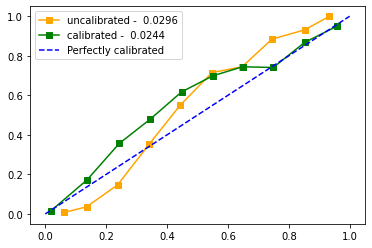

In [173]:
plot_calibration_curve(y_test, y_pred_focal, cali_y_pred_focal)

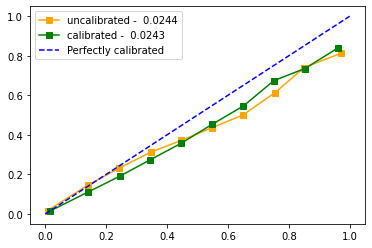

In [174]:
plot_calibration_curve(y_test, y_pred_bce, cali_y_pred_bce)

In [175]:
auc = metrics.roc_auc_score(y_test, y_pred_focal)
print(f'focal testing auc: {auc: .4f}')
auc = metrics.roc_auc_score(y_test, cali_y_pred_focal)
print(f'focal cali testing auc: {auc: .4f}')

# print(f'testing auc: {metrics.roc_auc_score(y_test[:10000], lgbm_result['prediction']): .6f}')

focal testing auc:  0.8704
focal cali testing auc:  0.8704


In [176]:
auc = metrics.roc_auc_score(y_test, y_pred_bce)
print(f'bce testing auc: {auc: .4f}')
auc = metrics.roc_auc_score(y_test, cali_y_pred_bce)
print(f'bce cali testing auc: {auc: .4f}')

# print(f'testing auc: {metrics.roc_auc_score(y_test[:10000], lgbm_result['prediction']): .6f}')

bce testing auc:  0.8752
bce cali testing auc:  0.8752


In [178]:
blend_y_pred = (y_pred_bce + y_pred_focal)/2
blend_cali_y_pred = (cali_y_pred_bce + cali_y_pred_focal)/2
auc = metrics.roc_auc_score(y_test, blend_y_pred)
print(f'blend testing auc: {auc: .4f}')
auc = metrics.roc_auc_score(y_test, blend_cali_y_pred)
print(f'cali blend testing auc: {auc: .4f}')

# print(f'testing auc: {metrics.roc_auc_score(y_test[:10000], lgbm_result['prediction']): .6f}')

blend testing auc:  0.8751
cali blend testing auc:  0.8788


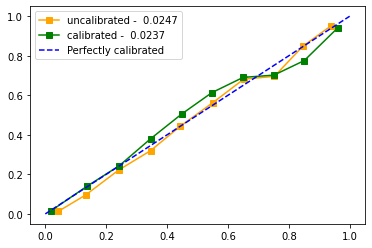

In [179]:
plot_calibration_curve(y_test, blend_y_pred, blend_cali_y_pred)

In [184]:
def compute_agg_table(rs_df, q, q_col):
    rs_df.quantile(q).loc[:,'pred_prob']
    all_cutoffs = rs_df.quantile(q).loc[:,q_col]

    total_fraud = sum(rs_df['fraud'])


    n_perc = []
    n_fraud = []
    money_saved = []
    p_fraud = []
    false_pos = []
    p_cutoff = []

    for perc, cutoff in zip(all_cutoffs.index, all_cutoffs.values):
    
        pos_mask = rs_df[q_col] >= cutoff
    
        pos_df = rs_df[pos_mask]
        
        n_perc.append(perc)
        n_fraud.append(sum(pos_df['fraud']))
        money_saved.append(sum(pos_df['fraud'] * pos_df['transaction_amount']))
        p_fraud.append(sum(pos_df['fraud']) / total_fraud)
        false_pos.append(len(pos_df) - sum(pos_df['fraud']))
        p_cutoff.append(cutoff)

    agg_df = pd.DataFrame()
    agg_df['percentile'] = n_perc
    agg_df['cutoff'] = p_cutoff
    agg_df['no_of_fraud'] = n_fraud
    agg_df['fraud_money_value'] = money_saved
    agg_df['total_amount'] = [sum(rs_df['transaction_amount'])] * len(n_perc)
    agg_df['percent_fraud'] = p_fraud
    agg_df['u_2fa'] = false_pos
    
    return agg_df


def generate_result_table(cali_y_pred, y_pred,X, y, q = np.array(range(75,100))/100, q_col = 'pred_prob'):
    result_df = pd.DataFrame()
    result_df['fraud'] = y
    result_df['transaction_amount'] = X['TransactionAmt']
    result_df['pred_prob'] = cali_y_pred
    result_df['risk'] = result_df['transaction_amount'] * result_df['pred_prob']
    result_df['uncalibrated_pred_prob'] = y_pred
    
    agg_df = compute_agg_table(result_df, q, q_col)

    return result_df, agg_df
    

In [187]:
rs_df, ag_df = generate_result_table(blend_cali_y_pred, blend_y_pred, test_df, y_test)

In [188]:
rs_df.to_csv('rs_blend_NN.csv', index=False)
ag_df.to_csv('ag_blend_NN.csv', index=False)